In [ ]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd

In [10]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [11]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [ ]:
def calculate_volume_anomaly_factor(df):
    """
    计算基于成交量异常的因子
    步骤：
    1. 在历史窗口(100周期)内识别异常点(volume > μ + 2σ)
    2. 筛选可用异常点(确保后续收益率数据完全可用)
    3. 计算所有异常点后续收益率的正负差异
    """
    # 参数设置
    N_periods = 100  # 历史窗口大小
    N_returns = 10   # 收益率序列长度
    
    # 初始化因子值序列
    factor_values = pd.Series(np.nan, index=df.index)
    
    # 预计算收益率 (使用开盘价到收盘价的收益率)
    returns = (df['close'] - df['open']) / df['open']
    
    # 遍历每个时间点
    for i in range(N_periods, len(df)):
        # 获取历史窗口数据 [t-N_periods, t-1]
        window = df.iloc[i - N_periods : i]
        
        # 步骤1: 识别异常点
        # 剔除volume极端值(前5%和后5%)
        vol = window['volume']
        q_low = vol.quantile(0.05)
        q_hi = vol.quantile(0.95)
        filtered_vol = vol[(vol >= q_low) & (vol <= q_hi)]
        
        # 计算均值和标准差
        mu = filtered_vol.mean()
        sigma = filtered_vol.std()
        
        # 识别异常点 (volume > μ + 2σ)
        anomaly_mask = (vol > mu + 2 * sigma)
        anomaly_points = window[anomaly_mask]
        
        # 步骤2: 筛选可用异常点
        valid_anomalies = []
        for idx in anomaly_points.index:
            pos = df.index.get_loc(idx)
            # 确保后续收益率数据完全可用 (s + N_returns <= t-1)
            if pos + N_returns < i:
                valid_anomalies.append(idx)
        
        # 步骤3: 计算因子值
        all_returns = []
        for idx in valid_anomalies:
            start_pos = df.index.get_loc(idx) + 1
            end_pos = start_pos + N_returns
            # 提取后续收益率序列
            ret_sequence = returns.iloc[start_pos:end_pos]
            all_returns.extend(ret_sequence.values)
        
        if len(all_returns) > 0:
            # 计算正负收益率差异
            all_returns = np.array(all_returns)
            positive_returns = all_returns[all_returns > 0]
            negative_returns = all_returns[all_returns < 0]
            
            mean_positive = positive_returns.mean() if len(positive_returns) > 0 else 0
            mean_negative = negative_returns.mean() if len(negative_returns) > 0 else 0
            
            factor_value = mean_positive - mean_negative
            factor_values.iloc[i] = factor_value
    
    return factor_values

# 测试因子表现


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): 0.014999
   Rank_IC (Spearman): 0.020517
📊 信息比率:
   IR: 0.257489
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 130929
   因子列: volume_anomaly_factor
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------
📊 显示分组分析图...


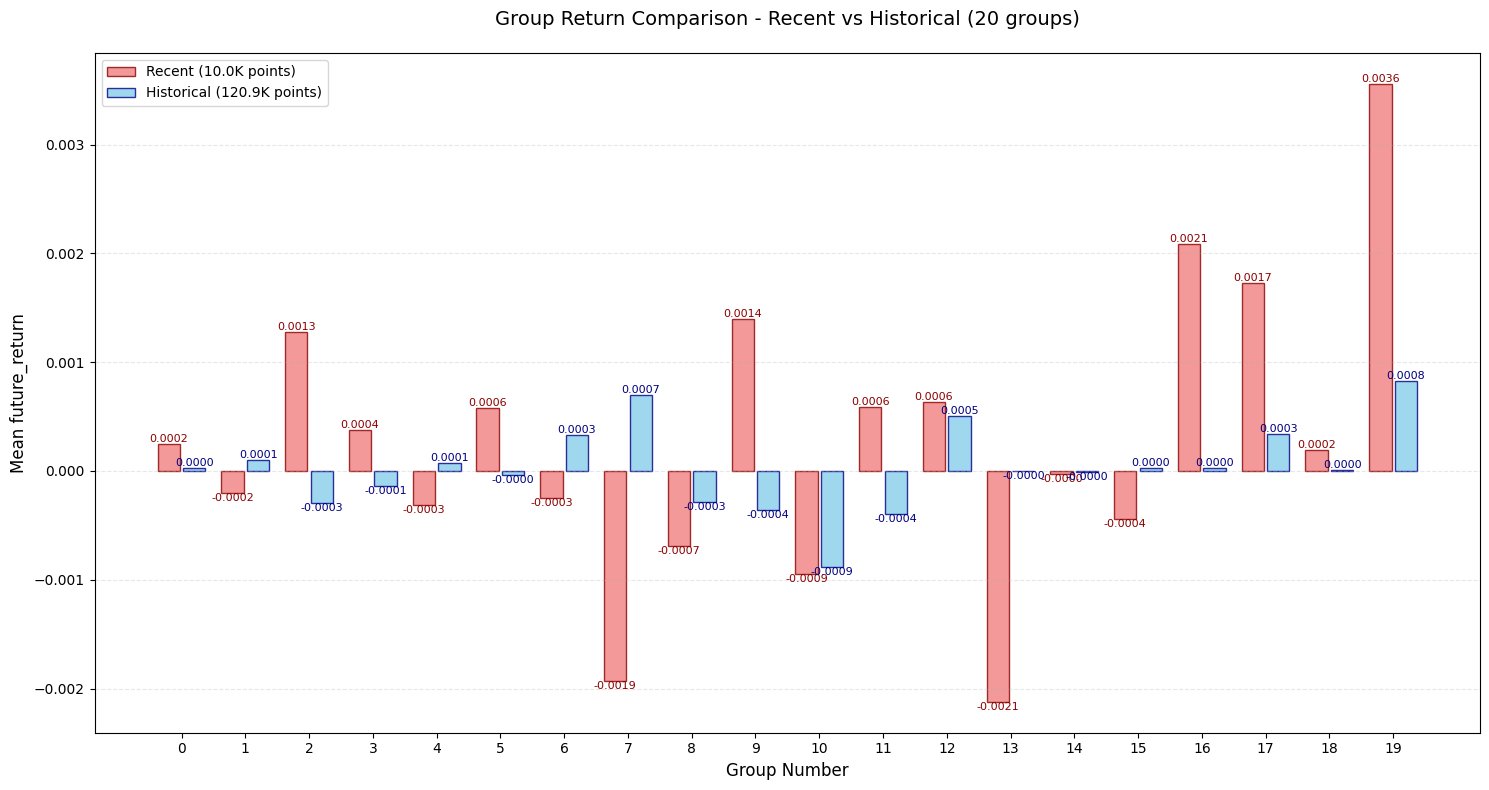

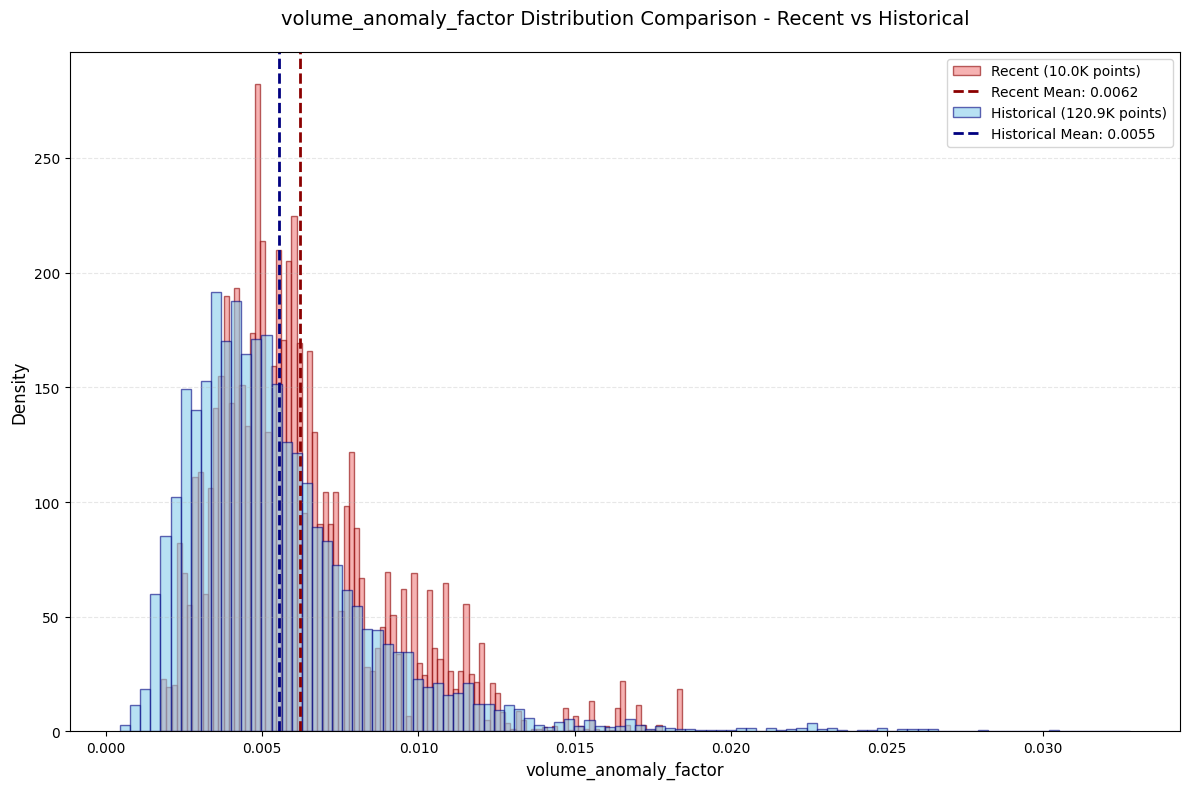

📈 显示因子分布图...
✅ 已显示 2 个图片
----------------------------------------


In [13]:
evaluator.set_factor(
    factor_func=calculate_volume_anomaly_factor,
    factor_name='volume_anomaly_factor'
)

result=evaluator.run_full_evaluation(run_stationarity_test=False)

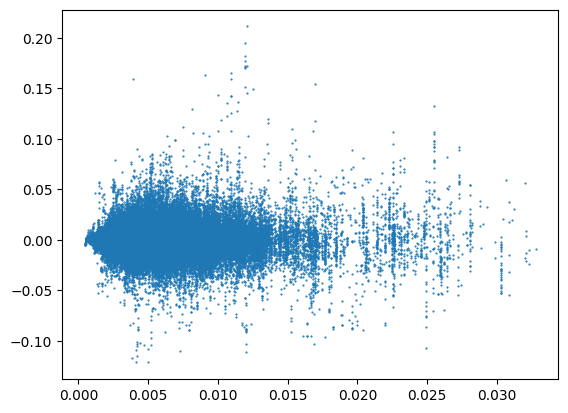

In [14]:
import matplotlib.pyplot as plt
plt.scatter(calculate_volume_anomaly_factor(df),df['close'].pct_change(-10), s=0.3)

In [15]:
result['information_ratio']['group_correlations']
# 这表示不同分组之间的相关性，通常用于评估因子在不同市场状态下的表现一致性。
# 如果相关性较高，说明因子在不同市场状态下表现一致；如果相关性较低，说明因子在不同市场状态下表现差异较大。

[-0.006444252893722754,
 0.00746371041502291,
 0.002405043324605262,
 0.004105792329549553,
 -0.020171889085524766,
 0.0509276956923026,
 -0.012243978126788293,
 -0.001483052339175985,
 0.011747319250665737,
 0.010479029476504158]

In [16]:
print(result)

{'correlation_analysis': {'IC': 0.01499895252663518, 'Rank_IC': 0.020516689313119073}, 'information_ratio': {'IR': 0.25748872927713723, 'group_correlations': [-0.006444252893722754, 0.00746371041502291, 0.002405043324605262, 0.004105792329549553, -0.020171889085524766, 0.0509276956923026, -0.012243978126788293, -0.001483052339175985, 0.011747319250665737, 0.010479029476504158], 'n_groups': 10}, 'group_analysis': {'group_stats':        val_min  val_max  val_mean  return_mean  return_std  count
group                                                            
0       0.0004   0.0020    0.0016       0.0001      0.0054   6547
1       0.0020   0.0025    0.0023      -0.0001      0.0068   6546
2       0.0025   0.0029    0.0027      -0.0002      0.0074   6549
3       0.0029   0.0032    0.0030      -0.0001      0.0074   6547
4       0.0032   0.0035    0.0034       0.0001      0.0083   6545
5       0.0035   0.0038    0.0036       0.0000      0.0085   6566
6       0.0038   0.0041    0.0039       